# Load Datasets

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = data['filenames']
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load test dataset
test_files, test_targets = load_dataset('data/dogImages/test')

# Load list of dog names
dog_names = [item[item.index('.')+1:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# Load model training/testing/validation stats

In [2]:
import pickle
dog_model_metrics = {}
with open('model.metrics', 'rb') as file:
    dog_model_metrics = pickle.load(file)
dog_model_metrics

{'VGG16': {'history': {'loss': [9.890192985534668,
    3.3358840942382812,
    2.011549711227417,
    1.4879122972488403,
    1.1217032670974731,
    0.9385378360748291,
    0.7710722088813782,
    0.6517816185951233,
    0.5547191500663757,
    0.47218796610832214,
    0.42751094698905945,
    0.4093029201030731,
    0.34397149085998535,
    0.328975647687912,
    0.2825600206851959,
    0.25588756799697876,
    0.2285071462392807,
    0.2261619120836258,
    0.20270326733589172,
    0.19258446991443634],
   'accuracy': [0.1838323324918747,
    0.5038922429084778,
    0.6531437039375305,
    0.7287425398826599,
    0.7754490971565247,
    0.8044910430908203,
    0.8350299596786499,
    0.8540419340133667,
    0.8706586956977844,
    0.8865269422531128,
    0.8998503088951111,
    0.9031437039375305,
    0.9131736755371094,
    0.919910192489624,
    0.927395224571228,
    0.9329341053962708,
    0.9347305297851562,
    0.939970076084137,
    0.9444611072540283,
    0.9471557140350342]

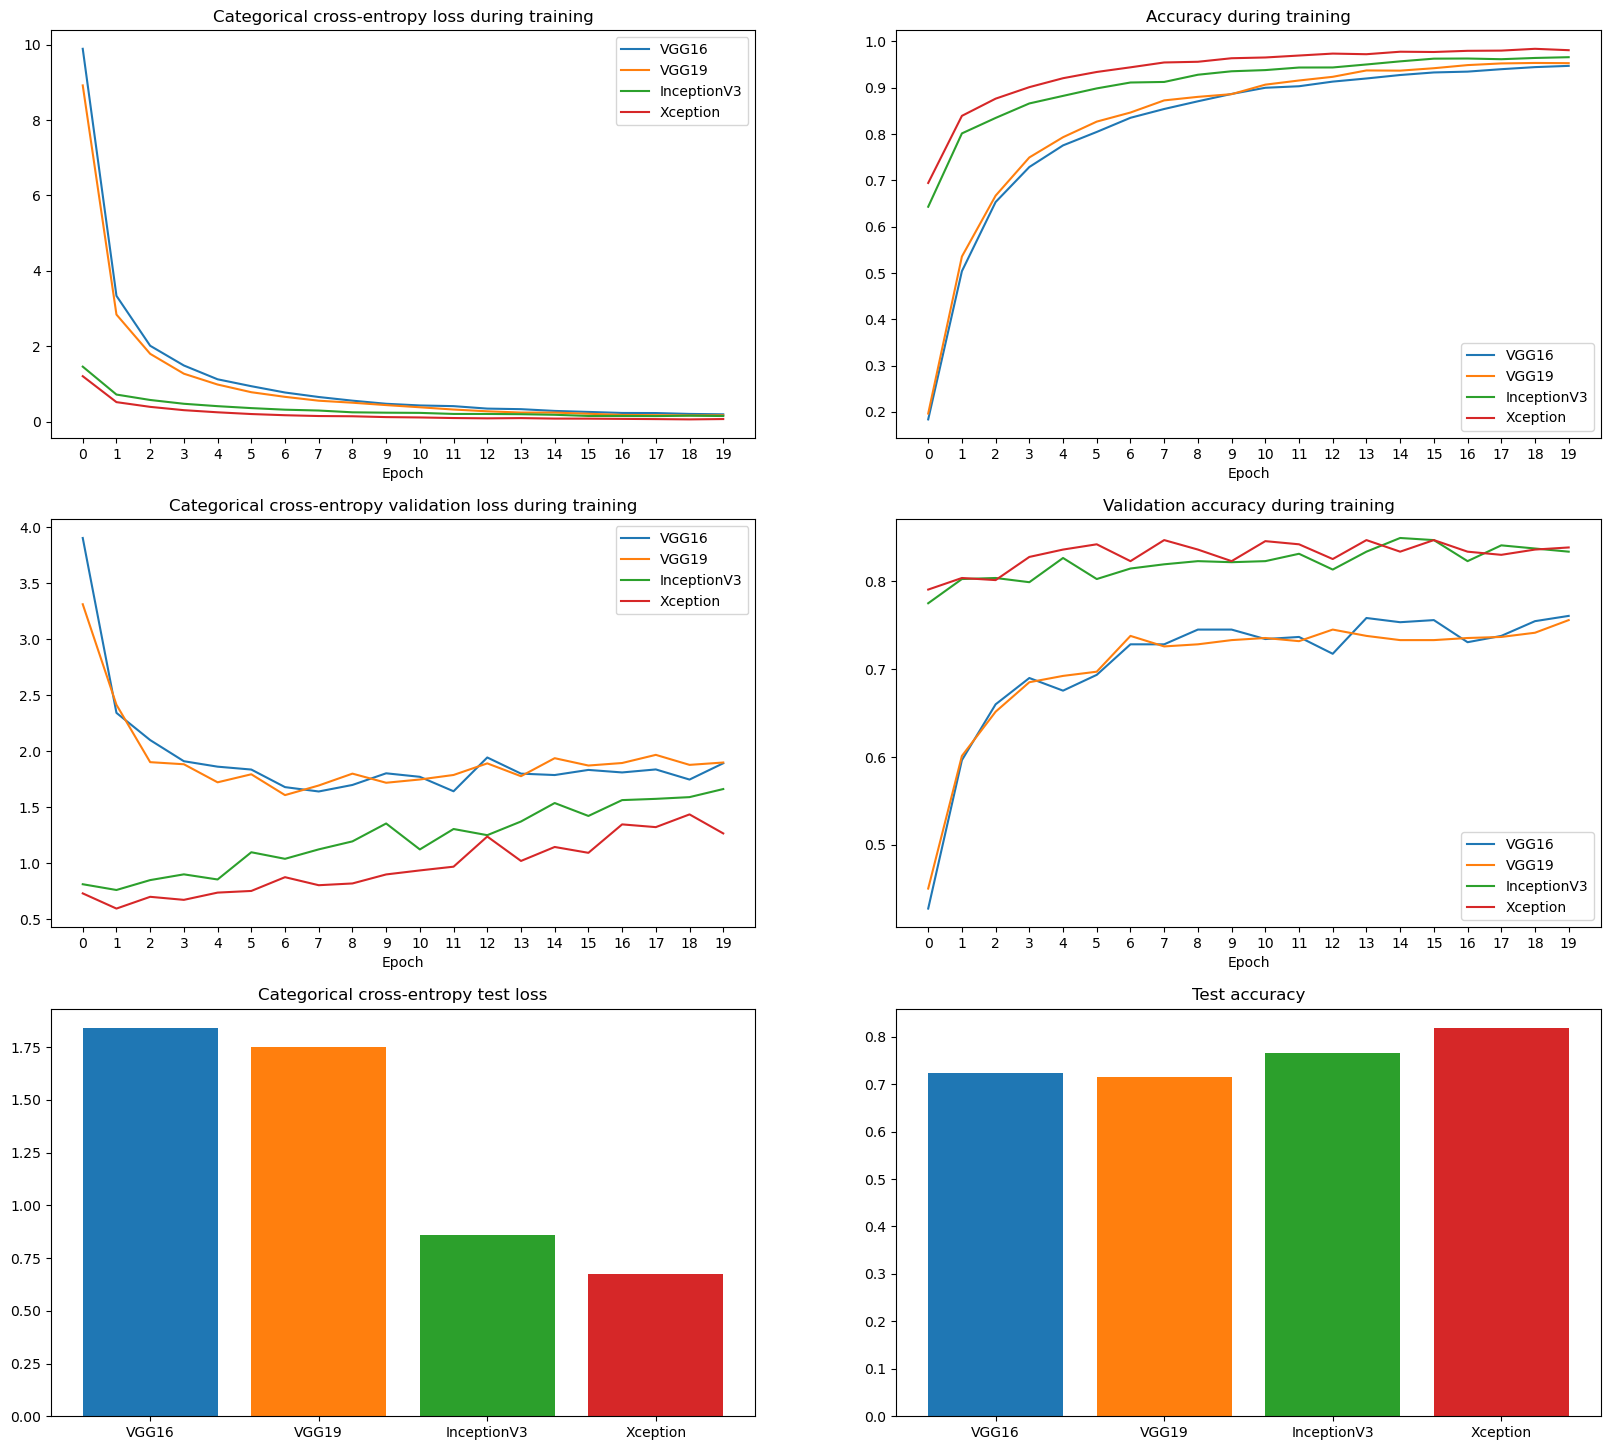

In [3]:
import matplotlib.pyplot as plt
#For each model, plot accuracy and loss for both training and validation
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,18))
ax1.set_title('Categorical cross-entropy loss during training')
ax1.set_xlabel('Epoch')
for network in dog_model_metrics:
    loss = dog_model_metrics[network]['history']['loss']
    ax1.plot(loss, label=network)
ax1.set_xticks(range(len(dog_model_metrics[network]['history']['loss'])))
ax1.legend()

ax2.set_title('Accuracy during training')
ax2.set_xlabel('Epoch')
for network in dog_model_metrics:
    loss = dog_model_metrics[network]['history']['accuracy']
    ax2.plot(loss, label=network)
ax2.set_xticks(range(len(dog_model_metrics[network]['history']['accuracy'])))
ax2.legend()

ax3.set_title('Categorical cross-entropy validation loss during training')
ax3.set_xlabel('Epoch')
for network in dog_model_metrics:
    loss = dog_model_metrics[network]['history']['val_loss']
    ax3.plot(loss, label=network)
ax3.set_xticks(range(len(dog_model_metrics[network]['history']['val_loss'])))
ax3.legend()

ax4.set_title('Validation accuracy during training')
ax4.set_xlabel('Epoch')
for network in dog_model_metrics:
    loss = dog_model_metrics[network]['history']['val_accuracy']
    ax4.plot(loss, label=network)
ax4.set_xticks(range(len(dog_model_metrics[network]['history']['val_accuracy'])))
ax4.legend()

ax5.set_title('Categorical cross-entropy test loss')
for network in dog_model_metrics:
    ax5.bar(network, dog_model_metrics[network]['test_loss'])

ax6.set_title('Test accuracy')
for network in dog_model_metrics:
    ax6.bar(network, dog_model_metrics[network]['test_accuracy'])

# Create model stats on entire training dataset

- Construct dataframe with columns `model`, `file`, `predicted`, and `actual`
- Save dataframe as pickle

## Data Preprocessing Functions

In [4]:
from tensorflow.keras.utils import img_to_array, load_img
from tqdm import tqdm

#Convert image path 
def path_to_tensor(img_path):
    try:
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        # Normalize the image tensor
        return np.expand_dims(x, axis=0)
    except IOError:
        print(f"Warning: Skipping corrupted image {img_path}")
        return None
def paths_to_tensor(img_paths):
    batch_tensors = []
    for img_path in img_paths:
        tensor = path_to_tensor(img_path)
        if tensor is not None:
            batch_tensors.append(tensor[0])
    return np.array(batch_tensors)

## Load models and corresponding preprocessing functions

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16pp
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19pp
from tensorflow.keras.applications.xception import Xception, preprocess_input as xceptionpp
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inceptionv3pp
from tensorflow.keras.models import load_model

#Create final model by concatenated pre-trained model with transfer learning model
pre_trained_models = {}
transfer_models = {}
preprocessing = {}

#get pre-trained models and corresponding preprocess_input functions
pre_trained_models['VGG16'] = VGG16(weights='imagenet', include_top=False)
preprocessing['VGG16'] = vgg16pp
pre_trained_models['VGG19'] = VGG19(weights='imagenet', include_top=False)
preprocessing['VGG19'] = vgg19pp
pre_trained_models['Xception'] = Xception(weights='imagenet', include_top=False)
preprocessing['Xception'] = xceptionpp
pre_trained_models['InceptionV3'] = InceptionV3(weights='imagenet', include_top=False)
preprocessing['InceptionV3'] = inceptionv3pp

#get best trained models
for network in ['VGG16', 'VGG19', 'InceptionV3', 'Xception']:
    transfer_models[network] = load_model(f'saved_models/weights.best.{network}.hdf5')

## Get predictions

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allow loading of truncated images

predictions = {}
for model in transfer_models:
    inputs = paths_to_tensor(test_files) #need to recompute input tensor every time
    features = pre_trained_models[model].predict(preprocessing[model](inputs))
    predictions[model] = transfer_models[model].predict(features)

valid_paths = [p for p in test_files if path_to_tensor(p) is not None]
indices = [np.where(test_files == img_path)[0][0] for img_path in valid_paths]
targets = np.array([test_targets[index] for index in indices])

27/27 [==============================] - 0s 3ms/step


## Construct dataframe

In [7]:
import pandas as pd
#record predicted and actual for each model/file combination
records = []
for model in transfer_models:
    for i in indices:
        target = test_targets[i]
        record = {}
        record['model'] = model
        record['file'] = test_files[i][test_files[i].rindex('\\')+1:]
        record['predicted'] = dog_names[np.argmax(predictions[model][i])]
        record['actual'] = dog_names[np.argmax(target)]
        records.append(record)
model_preds = pd.DataFrame.from_records(records)
model_preds['accuracy'] = model_preds['predicted'] == model_preds['actual']
model_preds

,model,file,predicted,actual,accuracy
0,VGG16,Dalmatian_04056.jpg,Dalmatian,Dalmatian,True
1,VGG16,Doberman_pinscher_04156.jpg,Doberman_pinscher,Doberman_pinscher,True
2,VGG16,Papillon_07480.jpg,Papillon,Papillon,True
3,VGG16,Bedlington_terrier_01363.jpg,Bedlington_terrier,Bedlington_terrier,True
4,VGG16,Flat-coated_retriever_04703.jpg,Flat-coated_retriever,Flat-coated_retriever,True
...,...,...,...,...,...
3339,Xception,Pekingese_07585.jpg,Pekingese,Pekingese,True
3340,Xception,Bloodhound_01871.jpg,Bloodhound,Bloodhound,True
3341,Xception,Japanese_chin_06175.jpg,Japanese_chin,Japanese_chin,True
3342,Xception,Greyhound_05530.jpg,Greyhound,Greyhound,True


<Axes: xlabel='model'>

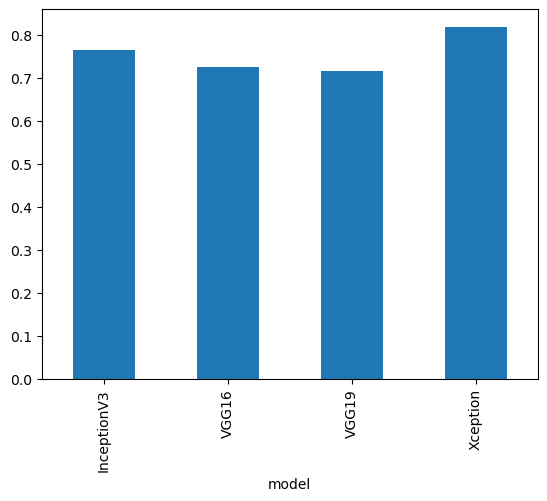

In [8]:
#accuracy matches what we had in the other notebook
model_preds.groupby('model')['accuracy'].mean().plot.bar()

In [ ]:
import pickle
with open('model_preds.df', 'wb') as file:
    pickle.dump(model_preds, file)